# The Viterbi Algorithm

In [15]:
from io import open

from nltk import FreqDist
from nltk import WittenBellProbDist
from nltk.util import ngrams

from conllu import parse_incr

corpora = {}
corpora['English'] = 'UD_English-EWT/en_ewt'
corpora['Chinese'] = 'UD_Chinese-GSDSimp/zh_gsdsimp'
corpora['German'] = 'UD_German-GSD/de_gsd'
corpora['Hebrew'] = 'UD_Hebrew-HTB/he_htb'

def train_corpus(lang):
	return corpora[lang] + '-ud-train.conllu'

def test_corpus(lang):
	return corpora[lang] + '-ud-test.conllu'

# Remove contractions such as "isn't".
def prune_sentence(sent):
	return [token for token in sent if type(token['id']) is int]

def conllu_corpus(path):
	data_file = open(path, 'r', encoding='utf-8')
	sents = list(parse_incr(data_file))
	return [prune_sentence(sent) for sent in sents]

# Choose language.
lang = 'English'

# Limit length of sentences to avoid underflow.
max_len = 100

train_sents = conllu_corpus(train_corpus(lang))
test_sents = conllu_corpus(test_corpus(lang))
test_sents = [sent for sent in test_sents if len(sent) <= max_len]

print(len(train_sents), 'training sentences')
print(len(test_sents), 'test sentences')

universal_pos_set = {}

##
## Below is the how we derive transition probs 
## and emission probs from the training sentences
##

def derive_words_tags_grams(sentences):
  tags_grams = []
  tagged_words = []
  tags = []
  for sent in sentences:
    tagged_words.append(['<s>', 'START'])
    tags.append('START')
    previous_tag = 'START'
    for token in sent:
      tags_grams.append([previous_tag, token['upos']])
      tagged_words.append([token['form'], token['upos']])
      tags.append(token['upos'])
      previous_tag = token['upos']

    tags_grams.append([previous_tag, 'END'])
    tagged_words.append(['</s>', 'END'])
    tags.append('END')
  return [tagged_words, set(tags), tags_grams]

words_tags_grams = derive_words_tags_grams(train_sents)
tags_set = words_tags_grams[1]
tagged_words = words_tags_grams[0]
tags_grams = words_tags_grams[2]

# the tag set of English is the universal_pos_set
universal_pos_set = tags_set

def derive_smoothed_emit(tagged_words, tags_set):
  smoothed_emit = {}
  for tag in tags_set:
    ws = [w for (w,t) in tagged_words if t == tag]
    smoothed_emit[tag] = WittenBellProbDist(FreqDist(ws), bins=1e5)
  return smoothed_emit

def derive_smoothed_trans(tags_grams, tags_set):
  smoothed_trans = {}
  for tag in tags_set:
      following_tag = [t2 for (t1,t2) in tags_grams if t1 == tag]
      smoothed_trans[tag] = WittenBellProbDist(FreqDist(following_tag), bins=1e5)
  return smoothed_trans

smoothed_emit = derive_smoothed_emit(tagged_words, tags_set)
smoothed_trans = derive_smoothed_trans(tags_grams, tags_set)

##
## Below is how we tag test sentences
##

correct_count = 0
total_count = 0

for sent in test_sents:
  tags_test = []
  #tags_test.append('START')
  for token in sent:
    tags_test.append(token['upos'])
  #tags_test.append('END')

  tags_predict = []
  tag_prob = {}

  # for the word at start
  for tag in tags_set:
    word = sent[0]['form']
    tag_prob[tag]= smoothed_trans['START'].prob(tag) * smoothed_emit[tag].prob(word)

  # for words in middle
  previous_tag = {}
  for i in range(1,len(sent)):
    word = sent[i]['form']
    previous_tag_prob = tag_prob.copy()
    tag_prob = {}
    for tag2 in tags_set:
      prob_max = 0.0
      for tag1 in tags_set:
        prob = previous_tag_prob[tag1] * smoothed_trans[tag1].prob(tag2) * smoothed_emit[tag2].prob(word)
        if prob_max <= prob:
          prob_max = prob
          previous_tag_max_prob = tag1
      previous_tag[tag2,i] = previous_tag_max_prob
      tag_prob[tag2] = prob_max

  # for the word at end
  prob_max = 0.0
  for tag in tags_set:
    prob = tag_prob[tag]* smoothed_trans[tag].prob('END')
    if prob_max <= prob:
      prob_max = prob
      last_tag = tag

  #tags_predict = ['END']
  tags_predict.append(last_tag)
  for i in range(1, len(sent)):
    tag = tags_predict[-1]
    prev_tag = previous_tag[tag,(len(sent)-i)]
    tags_predict.append(prev_tag)

  #tags_predict.append('START')
  tags_predict.reverse()

  length = len(sent)
  #length = len(sent)+2
  for i in range(length):
    if tags_predict[i] == tags_test[i]:
      correct_count += 1
    total_count += 1

# If 'START' and 'END' tags are included in test sentences,
# the accuracy can reach 0.9103
accuracy = correct_count/total_count
print("accuracy =", correct_count, "/", total_count, "=", accuracy)

12543 training sentences
2077 test sentences
accuracy = 22475 / 25096 = 0.8955610455849538


# Investigate Languages

## Which of the chosen languages have a rich morphology and which have a poor morphology? 
What can you say about the relation between forms and lemmas in the case of languages with rich morphology?

In [16]:
# This method gives all morphological features in words

def derive_morph_features(sentences):
  all_feats = {}
  for sent in sentences:
    for token in sent:
      feats = token['feats']
      if feats != None:
        keys = feats.keys()
        for key in keys:
          if key in all_feats.keys():
            if feats[key] not in all_feats[key]:
              all_feats[key].append(feats[key])
          else:
            all_feats[key] = [feats[key]]

  # features that are the only feature in belonging field are to be deleted
  feats_to_be_deleted = []
  for key in all_feats.keys():
    if len(all_feats[key]) < 2:
      feats_to_be_deleted.append(key)

  for feat in feats_to_be_deleted:
    del all_feats[feat]

  return all_feats

In [17]:
import numpy as np

# This method return a list that contains the count of forms for each individual lemma
def derive_form_counts(sentences):
  lemma_forms = {}
  for sent in sentences:
    for token in prune_sentence(sent):
      lemma = token['lemma']
      form = token['form']
      if lemma in lemma_forms.keys():
        if form not in lemma_forms[lemma]:
          flag = 0
          for word_form in lemma_forms[lemma]:
            if form.lower() == word_form.lower():
              flag = 1
              break
          if flag == 0:
            lemma_forms[lemma].append(form)
      else:
        lemma_forms[lemma] = [form]

  form_counts = []
  for lemma in lemma_forms.keys():
    form_counts.append(len(lemma_forms[lemma]))
  return form_counts

English {'Number': ['Sing', 'Plur'], 'Degree': ['Pos', 'Cmp', 'Sup'], 'Mood': ['Ind', 'Imp'], 'Tense': ['Past', 'Pres'], 'VerbForm': ['Fin', 'Inf', 'Ger', 'Part'], 'Definite': ['Def', 'Ind'], 'PronType': ['Art', 'Dem', 'Prs', 'Rel', 'Int'], 'Case': ['Acc', 'Nom'], 'Person': ['1', '3', '2'], 'NumType': ['Card', 'Ord', 'Mult'], 'Gender': ['Masc', 'Neut', 'Fem']}
Chinese {'NumType': ['Card', 'Ord'], 'Person': ['3', '2', '1'], 'Aspect': ['Prog', 'Perf'], 'Voice': ['Pass', 'Cau']}
German {'Case': ['Nom', 'Gen', 'Dat', 'Acc'], 'Gender': ['Fem', 'Neut', 'Masc'], 'Number': ['Sing', 'Plur'], 'Definite': ['Def', 'Ind'], 'PronType': ['Art', 'Prs', 'Ind', 'Dem', 'Rel', 'Neg', 'Int'], 'Mood': ['Ind', 'Sub', 'Imp'], 'Person': ['1', '3', '2'], 'Tense': ['Pres', 'Past'], 'VerbForm': ['Fin', 'Inf', 'Part'], 'NumType': ['Card', 'Ord'], 'Number[psor]': ['Sing', 'Plur']}
Hebrew {'PronType': ['Art', 'Prs', 'Dem', 'Int', 'Emp', 'Ind'], 'Gender': ['Masc', 'Fem,Masc', 'Fem'], 'Number': ['Sing', 'Plur', 'Plur,

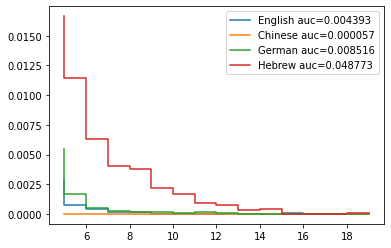

In [18]:
import matplotlib.pyplot as plt

##
## This block of code plots a figure showing the percentages of lemmas that have more than 4 ( >=5 ) forms
##

languages = {'English': '', 'Chinese': '', 'German': '', 'Hebrew':''}
form_counts = {}
form_counts_together = []
for lang in languages.keys():
  languages[lang] = conllu_corpus(train_corpus(lang))

  print(lang, derive_morph_features(languages[lang]))

  form_counts[lang] = derive_form_counts(languages[lang])

  #remove the extreme
  form_counts[lang].remove(max(form_counts[lang]))

  form_counts_together += form_counts[lang]

upper_bound = max(form_counts_together)
x = np.arange(5, upper_bound)

heights = {}
auc = {'English':0, 'Chinese':0, 'German':0, 'Hebrew':0}
for lang in languages.keys():
  probs = []
  for i in x:
    p = form_counts[lang].count(i)/len(form_counts[lang])
    probs.append(p)
    auc[lang] += p
  
  # we take the previous removed element into account when calculate AUC.
  auc[lang] += 1/len(form_counts[lang])
  heights[lang] = probs
  plt.step(x, y = heights[lang], label = '%s auc=%f' % (lang, auc[lang]))

plt.legend()
plt.savefig('steps.png', dpi=400)
plt.show()


## How similar are the chosen languages, in terms of bigram models of their parts of speech?

In [19]:
import pandas as pd
import seaborn as sns

# This method plot a heatmap for the transition matrix
def plot_bitrans_heatmap(lang):
  words_tags_grams = derive_words_tags_grams(languages[lang])
  tags_set = words_tags_grams[1]
  tagged_words = words_tags_grams[0]
  tags_grams = words_tags_grams[2]

  if lang != 'English':
    tags_set = universal_pos_set

  smoothed_trans = derive_smoothed_trans(tags_grams, tags_set)

  tags_list = list(tags_set)
  tags_list1 = []
  probs = []
  for tag1 in tags_list:
    tags_list1 += [tag1] * len(tags_list)
    for tag2 in tags_list:
      probs.append(smoothed_trans[tag1].prob(tag2))

  df = {'tag1':tags_list1, 'tag2':tags_list *len(tags_list), 'prob':probs}
  dataframe = pd.DataFrame(df)
  dataframe = dataframe.pivot("tag1", "tag2", "prob")
  ax = plt.axes()
  heatmap = sns.heatmap(dataframe, ax = ax, vmax = 1, vmin = 0, cmap = 'Reds')
  ax.set_title(lang)
  plt.savefig('%s_heatmap.png' %lang, dpi=400)
  plt.show()

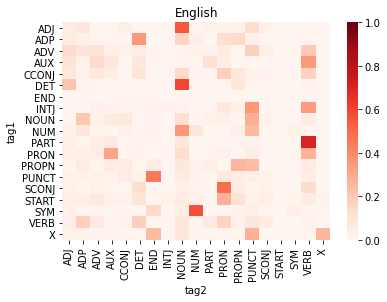

In [20]:
plot_bitrans_heatmap('English')

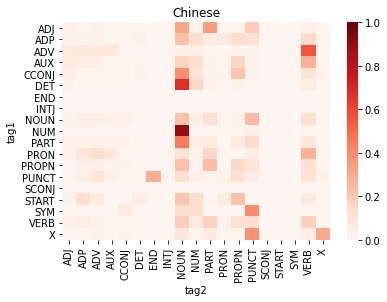

In [21]:
plot_bitrans_heatmap('Chinese')

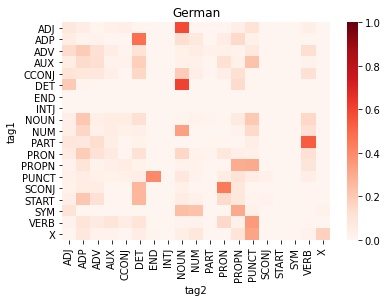

In [22]:
plot_bitrans_heatmap('German')

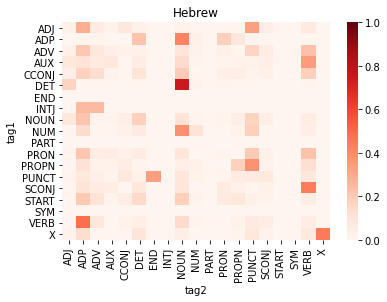

In [23]:
plot_bitrans_heatmap('Hebrew')

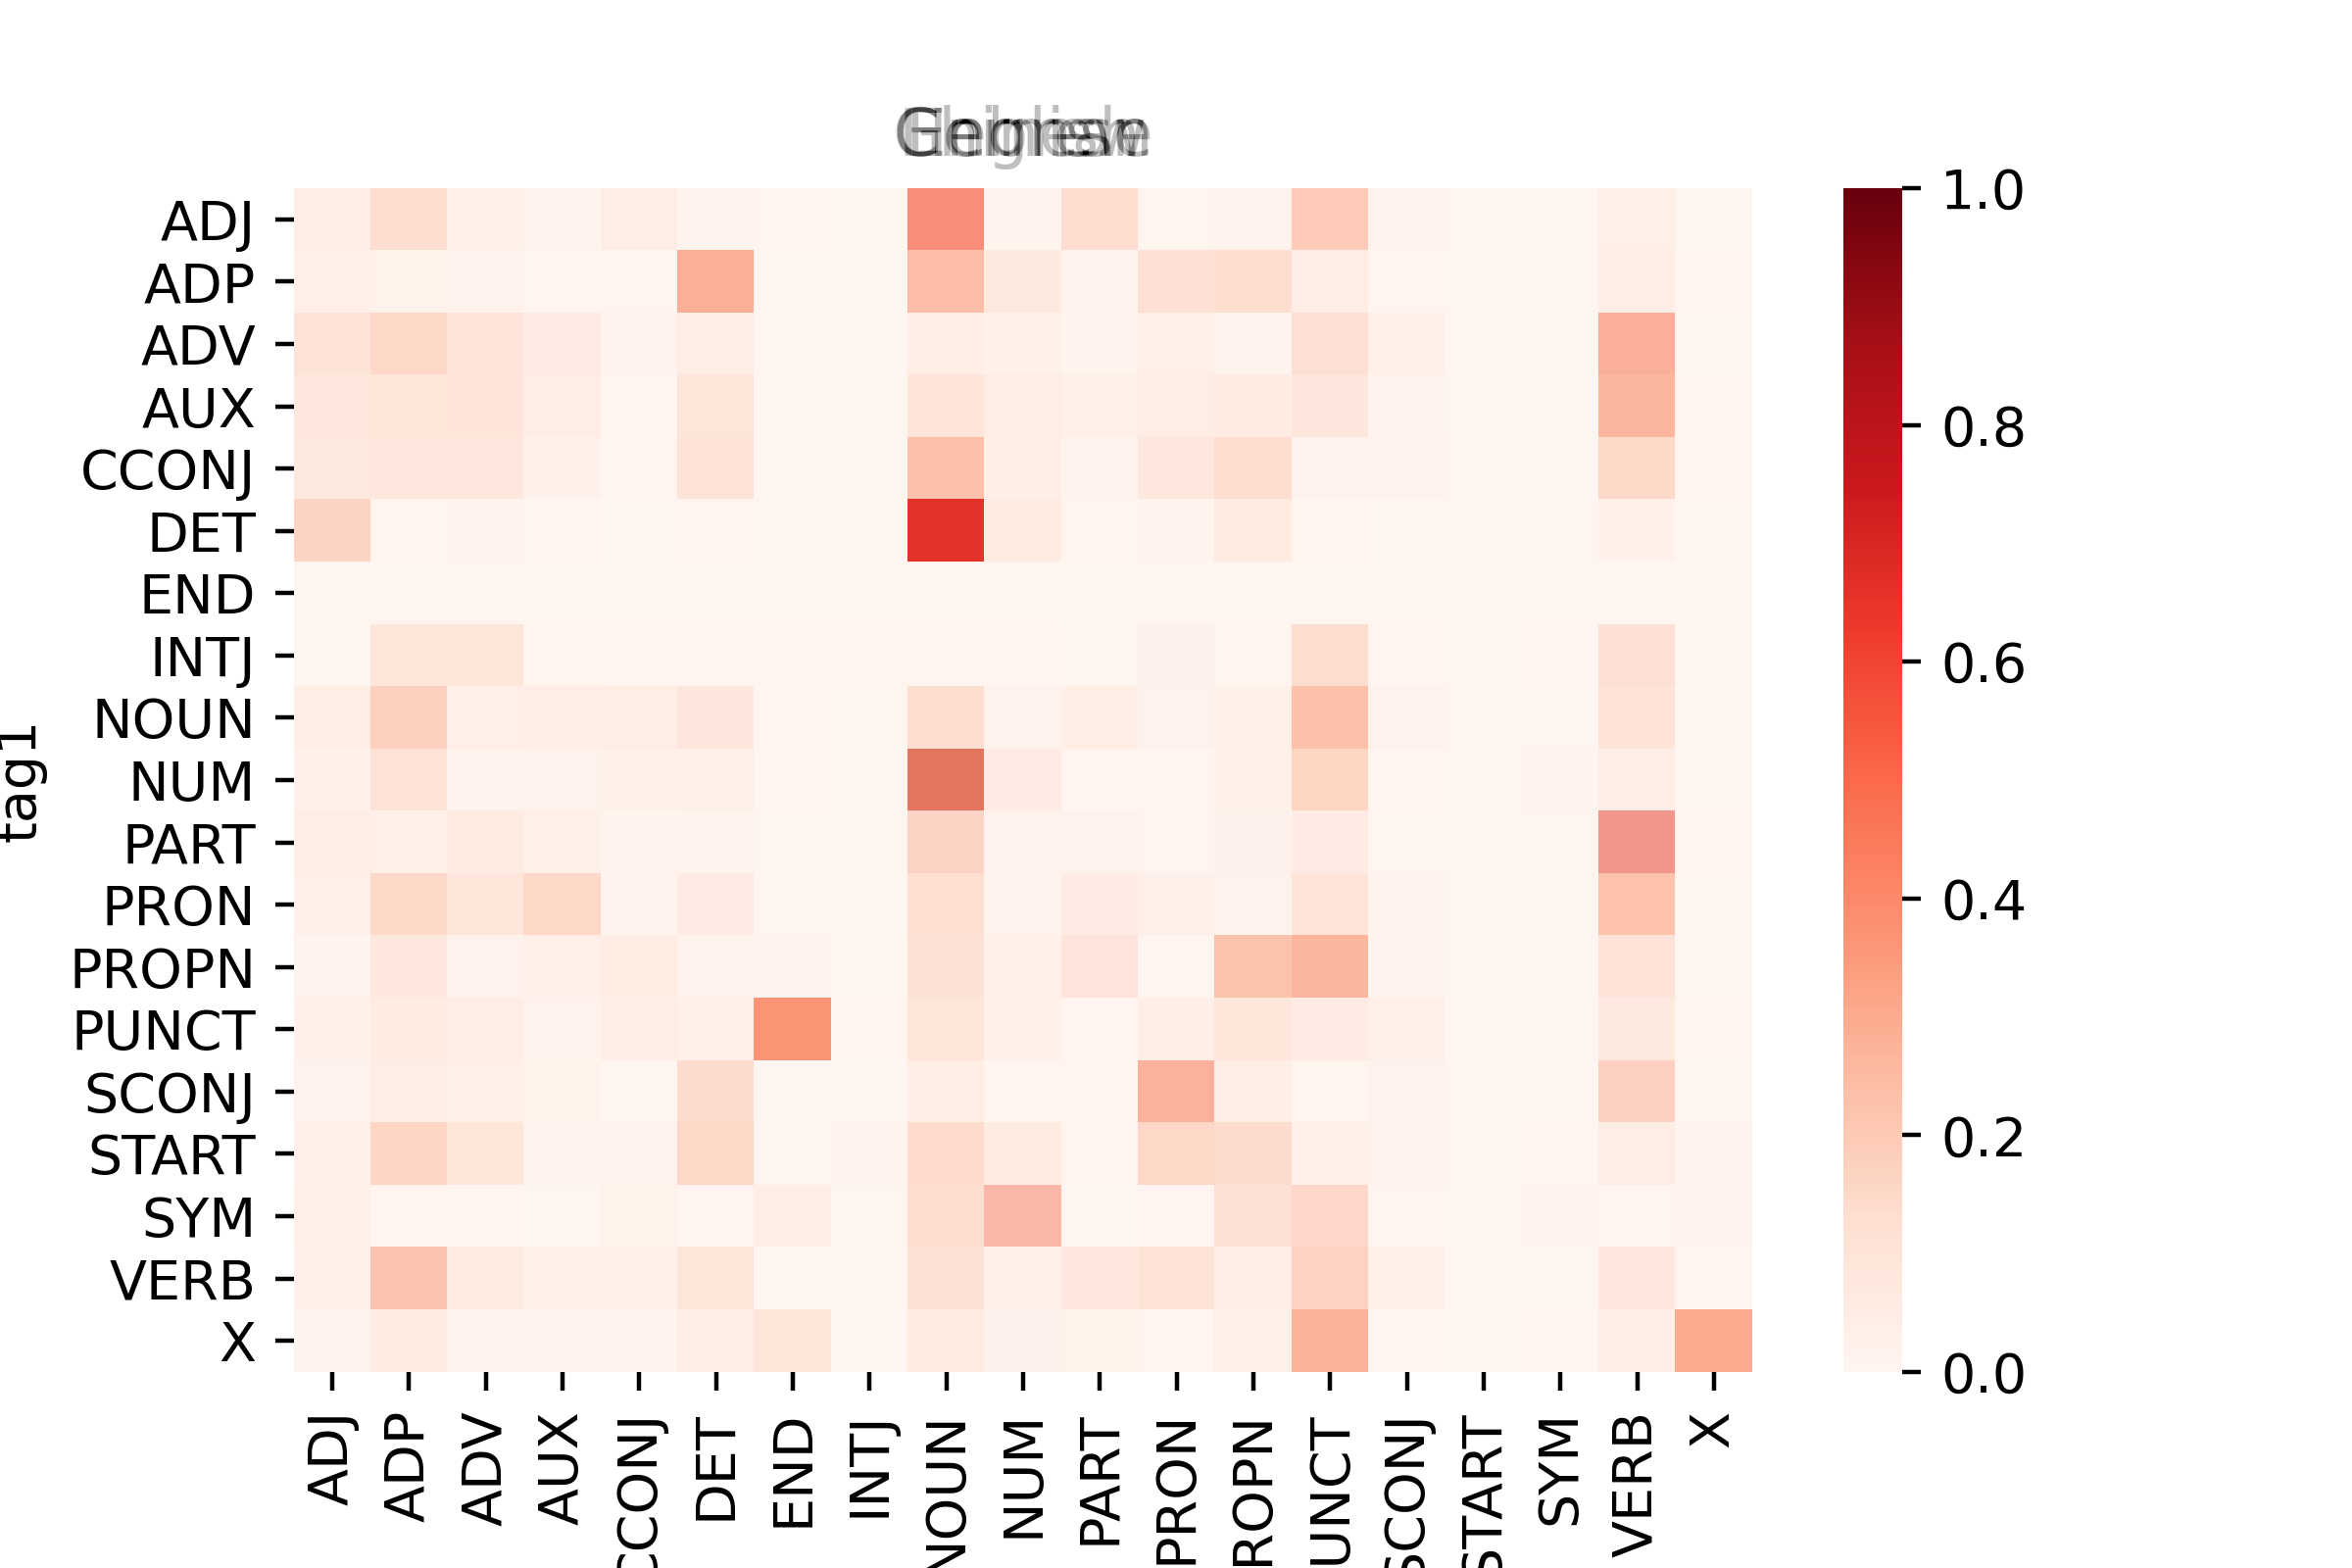

In [24]:
from PIL import Image

##
## This block of code overlap heatmaps of different languages. 
##

heatmaps = []
for lang in languages.keys():
  img = Image.open("%s_heatmap.png" %lang)
  heatmaps.append(img)

blend1 = Image.blend(heatmaps[0], heatmaps[1], alpha=0.5)
blend2 = Image.blend(heatmaps[2], heatmaps[3], alpha=0.5)
blended = Image.blend(blend1, blend2, alpha=0.5)
blended.save("blended.png")
blended

In [25]:

# This derive a similarity (in percentage) for transitions of two languages

def compare_trans_probs(lang1, lang2):
  words_tags_grams1 = derive_words_tags_grams(languages[lang1])
  tags_grams1 = words_tags_grams1[2]
  tags_set1 = universal_pos_set

  smoothed_trans1 = derive_smoothed_trans(tags_grams1, tags_set1)
  
  words_tags_grams2 = derive_words_tags_grams(languages[lang2])
  tags_grams2 = words_tags_grams2[2]
  tags_set2 = universal_pos_set

  smoothed_trans2 = derive_smoothed_trans(tags_grams2, tags_set2)

  baseline = 1/(len(universal_pos_set)-2)

  denominator = len(universal_pos_set) ** 2
  numerator = 0
  for tag2 in universal_pos_set:
    for tag1 in universal_pos_set:
      prob1 = smoothed_trans1[tag1].prob(tag2)
      prob2 = smoothed_trans2[tag1].prob(tag2)

      # We consider probs lower than 0.1 * baseline trivial
      if prob1 < 0.1 * baseline and prob2 < 0.1 * baseline:
        denominator -= 1
        continue
      
      # prob dif. within 2 * baseline is acceptable
      if max(prob1, prob2) - min(prob1, prob2) < 2 * baseline:
        numerator += 1

  return numerator/denominator

In [26]:
compares = {}
compares["English -- German"] = compare_trans_probs('English', 'German')
compares["English -- Chinese"]=compare_trans_probs('English', 'Chinese')
compares["English -- Hebrew"]=compare_trans_probs('English', 'Hebrew')
compares["Hebrew -- German"] = compare_trans_probs('Hebrew', 'German')
compares["German -- Chinese"] = compare_trans_probs('German', 'Chinese')
compares["Chinese -- Hebrew"] = compare_trans_probs('Chinese', 'Hebrew')

sorted(compares.items(), key = lambda item:item[1]) 

[('Chinese -- Hebrew', 0.7837837837837838),
 ('German -- Chinese', 0.8133971291866029),
 ('English -- Chinese', 0.8340080971659919),
 ('Hebrew -- German', 0.8591549295774648),
 ('English -- Hebrew', 0.860655737704918),
 ('English -- German', 0.9132231404958677)]